# Spectral Flatness

Plot [spectral flatness](https://ccrma.stanford.edu/workshops/mir2009/juans_lecture/3_feature.pdf) at specific loudness level.

In [10]:
import sys
sys.path.append('..')

In [11]:
import warnings
warnings.simplefilter('ignore', RuntimeWarning)
warnings.simplefilter('ignore', UserWarning)

In [12]:
import IPython.display as display
import librosa
import matplotlib.pyplot as plot
import numpy as np

from philharmonia import dataframe, datafile

In [13]:
import pyloudnorm

meter = None

def loudness(sample):

    x, sr = librosa.load(datafile(sample.file), sr=None, mono=True)

    global meter
    meter = meter or pyloudnorm.Meter(sr, block_size=100e-3)

    db = meter.integrated_loudness(x)

    return int(db)

In [14]:
def flatness(sample):

    x, sr = librosa.load(datafile(sample.file), sr=None, mono=True)

    magn = np.abs(np.fft.rfft(x * np.hanning(x.size))) ** 2

    prod = np.exp(np.mean(np.log(magn)))
    mean = np.mean(magn)

    flat = 20 * np.log10(prod / mean)

    return round(flat, 2)

In [15]:
query = [
    "(family != 'percussion' & style == 'normal' & length == '1')",
    "(family == 'percussion')",
]

filter = ['file', 'family', 'instrument']
sort = ['family', 'instrument', 'loudness', 'flatness']

data = dataframe().query(' | '.join(query)).filter(filter)

data['loudness'] = data.apply(lambda sample: loudness(sample), axis=1)
data['flatness'] = data.apply(lambda sample: flatness(sample), axis=1)

data = data.sort_values(sort)

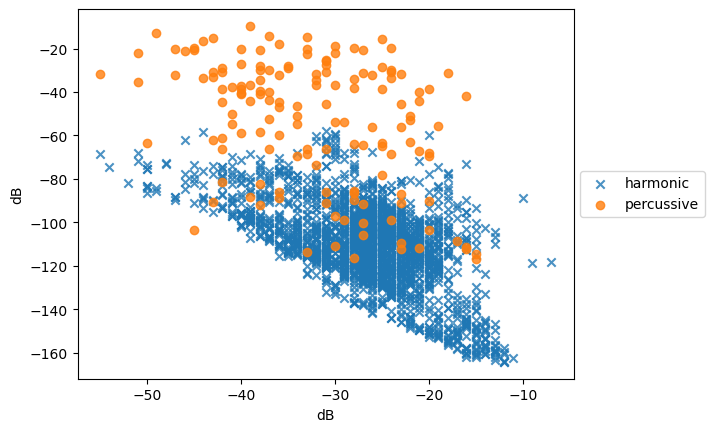

In [16]:
labels = { False: 'harmonic', True: 'percussive' }
markers = ['x', 'o']

for i, percussion in enumerate([False, True]):

    records = data[(data.family == 'percussion') == percussion]

    x = records.loudness.tolist()
    y = records.flatness.tolist()

    plot.scatter(x, y, label=labels[percussion], marker=markers[i%2], alpha=0.8)

plot.legend(loc='center left', bbox_to_anchor=(1, 0.5));
plot.xlabel('dB');
plot.ylabel('dB');

In [17]:
display.HTML(data.head(50).to_html())

,file,family,instrument,loudness,flatness
13845,brass/french horn/french-horn_Cs2_1_piano_normal.mp3,brass,french horn,-44,-89.85
14212,brass/french horn/french-horn_As1_1_piano_normal.mp3,brass,french horn,-44,-88.77
13915,brass/french horn/french-horn_Cs3_1_piano_normal.mp3,brass,french horn,-43,-90.33
13639,brass/french horn/french-horn_C4_1_piano_normal.mp3,brass,french horn,-42,-93.58
14049,brass/french horn/french-horn_D3_1_piano_normal.mp3,brass,french horn,-42,-93.22
13693,brass/french horn/french-horn_Gs2_1_piano_normal.mp3,brass,french horn,-41,-95.94
13711,brass/french horn/french-horn_As1_1_mezzo-forte_normal.mp3,brass,french horn,-41,-91.26
14110,brass/french horn/french-horn_B1_1_mezzo-forte_normal.mp3,brass,french horn,-41,-90.86
13738,brass/french horn/french-horn_G2_1_piano_normal.mp3,brass,french horn,-40,-97.07
13636,brass/french horn/french-horn_Cs4_1_piano_normal.mp3,brass,french horn,-40,-96.49
